In [3]:
import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import numpy as np
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200
from afqinsight import AFQDataset
from afqinsight.nn.utils import prep_pytorch_data
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from torch.distributions.normal import Normal
from sklearn.decomposition import PCA
import afqinsight.augmentation as aug
from afqinsight.nn.pt_models import Conv1DAutoencoder
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


In [4]:
import sys
# Adjust path as needed
# sys.path.insert(1, '/mmfs1/gscratch/nrdg/samchou/AFQ-Insight-Autoencoder-Experiments/Experiment_Utils')
sys.path.insert(1, '/Users/samchou/AFQ-Insight-Autoencoder-Experiments/AFQ-Insight-Autoencoder-Experiments/Experiment_Utils')
# Import necessary functions, including the new one
from utils import select_device, train_variational_autoencoder_age_site, kl_divergence_loss,prep_fa_flattned_data, GradReverse, prep_fa_flattened_remapped_data
from models import Conv1DVariationalAutoencoder_fa, AgePredictorCNN, SitePredictorCNN, CombinedVAE_Predictors

In [5]:
device = select_device()

Using device: mps

Using MPS backend on macOS. (Detailed memory info may not be available.)


In [6]:
dataset = AFQDataset.from_study('hbn')
torch_dataset, train_loader, test_loader, val_loader = prep_pytorch_data(dataset,batch_size=128)  

File /Users/samchou/.cache/afq-insight/hbn/subjects.tsv exists.
File /Users/samchou/.cache/afq-insight/hbn/nodes.csv exists.


/Users/samchou/src/nrdg/AFQ-Insight/afqinsight/transform.py:144: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  features = interpolated.stack(["subjectID", "tractID", "metric"]).unstack(


In [7]:
site_idx = dataset.target_cols.index('scan_site_id')
age_idx = dataset.target_cols.index('age')

In [8]:
torch_dataset, all_tracts_train_loader, all_tracts_test_loader, all_tracts_val_loader = prep_fa_flattned_data(dataset, batch_size=128)

_, test, _, _ = prep_fa_flattened_remapped_data(dataset, batch_size=128)

FA indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 21

In [9]:
print(all_tracts_train_loader.dataset[25][0].shape)
print(test.dataset[0][0].shape)

torch.Size([1, 100])
torch.Size([1, 100])


torch.Size([1, 100])


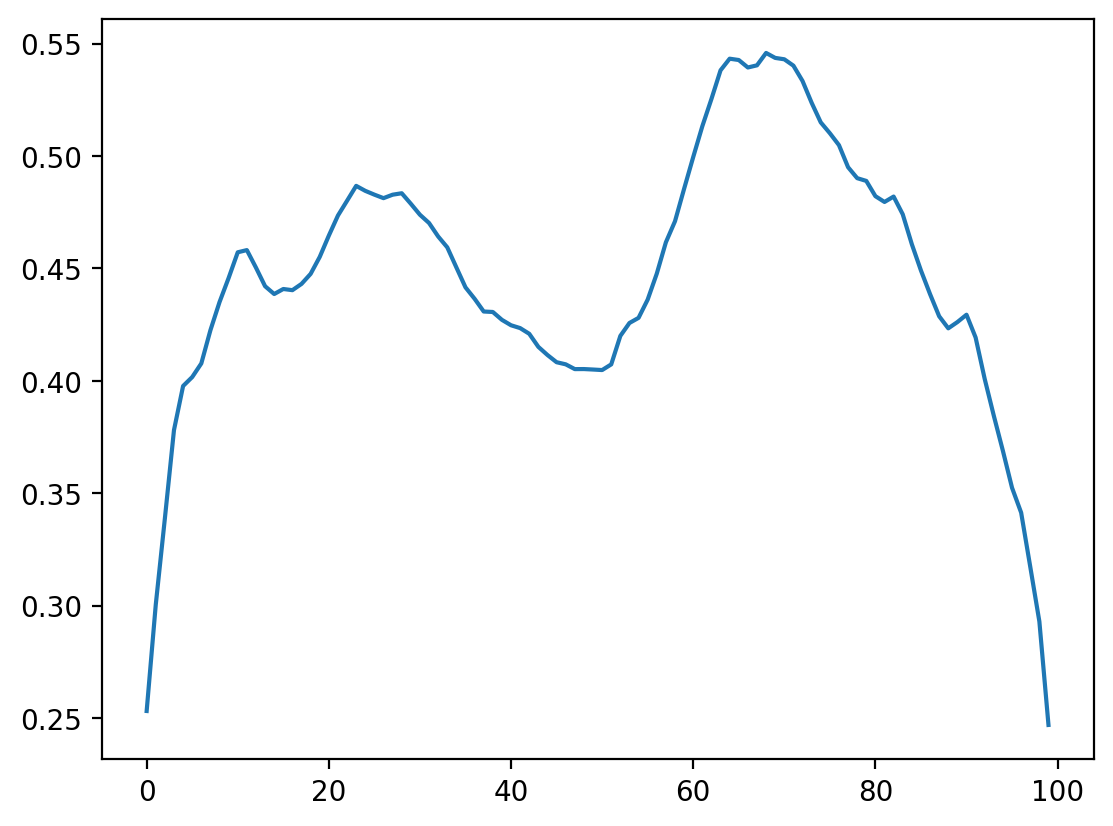

In [10]:
# Print the shape of the first sample's FA tract data
print(test.dataset[0][0].shape)

# Convert the first sample's FA tract data to a numpy array
arr = np.array(test.dataset[0][0])


# Plot the concatenated tracts data, transposed to show each tract as a line
plt.plot(arr[0])
plt.show()



In [11]:
print("Preparing initial PyTorch data loaders...")
try:
    # Assuming prep_pytorch_data returns torch_dataset, train_loader, test_loader, val_loader
    # If it returns datasets, create loaders here.
    # Adapt this call based on the actual signature and return values of your prep_pytorch_data
    prep_output = prep_fa_flattened_remapped_data(dataset, batch_size=128)
    if len(prep_output) == 4:
        _, train_loader_raw, test_loader_raw, val_loader_raw = prep_output
    else:
        raise ValueError(f"Expected 4 return values from prep_pytorch_data, got {len(prep_output)}")

    print("Initial data loaders prepared.")

    # Count samples per site

except Exception as e:
     print(f"Error calling prep_pytorch_data: {e}")
     print("Ensure the function exists and returns DataLoaders or required components.")
     sys.exit(1)

Preparing initial PyTorch data loaders...
FA indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 

In [12]:
site_counts = {}
for _, labels in train_loader_raw:
    site_labels = labels[:, 1]  # Assuming site is third column in labels
    for site in site_labels:
        site_id = site.item()
        site_counts[site_id] = site_counts.get(site_id, 0) + 1

print("\nNumber of samples per site in training set:")
for site_id, count in sorted(site_counts.items()):
    print(f"Site {site_id}: {count} samples")


Number of samples per site in training set:
Site 0.0: 20400 samples
Site 1.0: 36912 samples


In [13]:
if 'x_batch' in locals() and x_batch is not None:
    input_channels = x_batch.shape[1]
    sequence_length = x_batch.shape[2]
    print(f"Detected input shape: channels={input_channels}, sequence_length={sequence_length}")
else:
    print("Warning: Could not get sample batch to determine input shape.")
    # Set defaults or exit if necessary
    input_channels = 1 # Set manually if needed
    sequence_length = 100 # Set manually if needed (MUST MATCH VAE DECODER OUTPUT)
    print(f"Using default/manual input shape: channels={input_channels}, sequence_length={sequence_length}")

Using default/manual input shape: channels=1, sequence_length=50


In [14]:
# Define lists of hyperparameters to test
latent_dims = [32, 64]
dropout_values = [0.0]  # VAE dropout

# New separate dropout values for predictors
age_dropout_values = [0.0]
site_dropout_values = [0.0, 0.3]

# Define lists of weight values to test
w_recon_values = [1.0]
w_kl_values = [1.0, 0.1]
w_age_values = [3.0, 5.0]  # Higher weights to prioritize age prediction
w_site_values = [2.0, 3.0]  # Higher weights for stronger adversarial effect

# --- Storage for results ---
models = {}
results = {}

# --- Create results directory ---
save_directory = "experiment_results"
import os
os.makedirs(save_directory, exist_ok=True)
print(f"Results will be saved in: {save_directory}")


Results will be saved in: experiment_results


In [15]:
# --- Main Hyperparameter Loop ---
for dropout in dropout_values:
    for age_dropout in age_dropout_values:
        for site_dropout in site_dropout_values:
            for latent_dim in latent_dims:
                for w_recon in w_recon_values:
                    for w_kl in w_kl_values:
                        for w_age in w_age_values:
                            for w_site in w_site_values:
                                print("-" * 80)
                                print(f"STARTING RUN: LD={latent_dim}, DR_VAE={dropout}, DR_Age={age_dropout}, DR_Site={site_dropout}, wR={w_recon}, wKL={w_kl}, wA={w_age}, wS={w_site}")
                                print("-" * 80)

                                # --- Ensure input_channels and sequence_length are defined ---
                                if 'sequence_length' not in locals() or 'input_channels' not in locals():
                                    print("Error: sequence_length or input_channels not defined. Run previous cells.")
                                    break

                                # --- Instantiate Models ---
                                vae = Conv1DVariationalAutoencoder_fa(latent_dims=latent_dim, dropout=dropout)
                                age_predictor = AgePredictorCNN(input_channels=input_channels, 
                                                              sequence_length=sequence_length, 
                                                              dropout=age_dropout)
                                site_predictor = SitePredictorCNN(num_sites=num_sites, 
                                                                input_channels=input_channels, 
                                                                sequence_length=sequence_length, 
                                                                dropout=site_dropout)

                                combined_model = CombinedVAE_Predictors(vae, age_predictor, site_predictor)
                                combined_model = combined_model.to(device)

                                # --- Define unique prefix for this run's files ---
                                run_save_prefix = os.path.join(save_directory, 
                                    f"combo_ld{latent_dim}_drV{dropout}_drA{age_dropout}_drS{site_dropout}_wr{w_recon}_wkl{w_kl}_wa{w_age}_ws{w_site}")

                                # --- Train Model ---
                                try:
                                    training_results = train_variational_autoencoder_age_site(
                                        combined_model=combined_model,
                                        train_data=train_loader_raw,
                                        val_data=val_loader_raw,
                                        epochs=500,
                                        lr=0.001,
                                        device=device,
                                        max_grad_norm=1.0,
                                        w_recon=w_recon,
                                        w_kl=w_kl,
                                        w_age=w_age,
                                        w_site=w_site,
                                        kl_annealing_start_epoch=50,
                                        kl_annealing_duration=150,
                                        kl_annealing_start=0.001,
                                        grl_alpha_start=0.0,  # Start with stronger reversal
                                        grl_alpha_end=2.5,    # Increase max reversal strength
                                        grl_alpha_epochs=200,  # Reach max alpha faster
                                        save_prefix=run_save_prefix,
                                        val_metric_to_monitor="val_age_mae"
                                    )
                                except Exception as e:
                                    print(f"\n !!! Training failed for run {run_save_prefix}: {e} !!!\n")
                                    training_results = None

                                # --- Store Results ---
                                current_key = (latent_dim, dropout, age_dropout, site_dropout, w_recon, w_kl, w_age, w_site)
                                results[current_key] = training_results

                                # --- Process and Save Results if training finished ---
                                if training_results and training_results.get("model_path"):
                                    # Convert metrics to CPU floats
                                    keys_to_convert = [
                                        "train_loss_epoch", "val_loss_epoch", "train_recon_loss_epoch", "val_recon_loss_epoch",
                                        "train_kl_loss_epoch", "val_kl_loss_epoch", "train_age_loss_epoch", "val_age_loss_epoch",
                                        "train_site_loss_epoch", "val_site_loss_epoch", "train_age_mae_epoch", "val_age_mae_epoch",
                                        "train_site_acc_epoch", "val_site_acc_epoch", "current_beta_epoch",
                                        "current_grl_alpha_epoch", "current_lr_epoch"
                                    ]
                                    processed_results = {}
                                    for key in keys_to_convert:
                                        metric_list = training_results.get(key, [])
                                        new_list = []
                                        if isinstance(metric_list, (list, tuple)):
                                            for val in metric_list:
                                                if isinstance(val, torch.Tensor):
                                                    new_list.append(float(val.cpu().item()))
                                                elif isinstance(val, (int, float, np.number)):
                                                    new_list.append(float(val))
                                                else:
                                                    new_list.append(float('nan'))
                                        processed_results[key] = new_list

                                    # Convert best metrics
                                    best_mae_key = "best_val_age_mae"
                                    best_mae_val = training_results.get(best_mae_key)
                                    if isinstance(best_mae_val, torch.Tensor):
                                        best_mae = float(best_mae_val.cpu().item())
                                    elif isinstance(best_mae_val, (int, float, np.number)):
                                        best_mae = float(best_mae_val)
                                    else: 
                                        best_mae = float('nan')

                                    # Create DataFrame
                                    num_epochs = len(processed_results.get("train_loss_epoch", []))
                                    if num_epochs > 0:
                                        df_data = {"epoch": range(1, num_epochs + 1)}
                                        for k in keys_to_convert:
                                            col_name = k.replace('_epoch', '')
                                            metric_data = processed_results.get(k, [])
                                            if len(metric_data) != num_epochs:
                                                metric_data = [float('nan')] * num_epochs
                                            df_data[col_name] = metric_data

                                        df_epochs = pd.DataFrame(df_data)
                                        df_epochs.to_csv(f"{run_save_prefix}_metrics.csv", index=False)

                                        # Save summary metrics CSV
                                        df_summary = pd.DataFrame([{
                                            best_mae_key: best_mae,
                                            "best_epoch": training_results.get("best_epoch", float('nan')),
                                            "model_path": training_results.get("model_path", "N/A")
                                        }])
                                        df_summary.to_csv(f"{run_save_prefix}_summary.csv", index=False)

                                        print(f"Finished & Saved Run: {current_key}. Best Val MAE: {best_mae:.4f}")
                                    else:
                                        print(f"Skipping results saving for run {current_key} - No epoch data found.")
                                else:
                                    print(f"Skipping results processing for run {current_key} - Training did not complete or model not saved.")

# Indicate loop completion
print("\n" + "="*80)
print("Hyperparameter search loop finished.")
print("="*80 + "\n")

--------------------------------------------------------------------------------
STARTING RUN: LD=32, DR_VAE=0.0, DR_Age=0.0, DR_Site=0.0, wR=1.0, wKL=1.0, wA=3.0, wS=2.0
--------------------------------------------------------------------------------
[DEBUG] AgePredictorCNN: dummy input shape: torch.Size([1, 1, 50]), conv output shape: torch.Size([1, 128, 7]), flat_size: 896


NameError: name 'num_sites' is not defined